In [1]:
# mounting the google drive where the data csv files downloaded
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/train_combined.csv")
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_combined.csv")
neg, pos = np.bincount(train_data['isFraud'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (406,409,410,417,421,422,423,424,425,427,428,429,430,431,432,433,434) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (405,408,409,416,420,421,422,423,424,426,427,428,429,430,431,432,433) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
red_col = ['V1', 'V104', 'V107', 'V108', 'V11', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V13', 'V130', 'V136', 'V138', 'V139', 'V14', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V17', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V20', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V23', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V26', 'V260', 'V261', 'V264', 'V266', 'V267', 'V27', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285', 'V286', 'V289', 'V291', 'V294', 'V296', 'V297', 'V3', 'V30', 'V301', 'V303', 'V305', 'V307', 'V309', 'V310', 'V314', 'V320', 'V325', 'V332', 'V335', 'V338', 'V36', 'V37', 'V4', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V55', 'V56', 'V59', 'V6', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V8', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 'V98', 'V99']
# droping v cols 
drop_cols = [col for col in train_data.columns if col[0] == 'V' and col not in red_col]

In [5]:
print(f'dropping {len(drop_cols)} columns')
train_data = train_data.drop(columns=drop_cols)
test_data = test_data.drop(columns=drop_cols)

dropping 210 columns


In [6]:
useful_cols_tr = [col for col in train_data.columns if col not in ("TransactionID_x", "TransactionID_y", "TransactionDT")]
print(len(useful_cols_tr))

useful_cols = [col for col in train_data.columns if col not in ("isFraud","TransactionID_x", "TransactionID_y", "TransactionDT")]
print(len(useful_cols))

cols = [col for col in train_data]
cols.remove("isFraud")
test_data.columns = cols
x_test = test_data[useful_cols].reset_index(drop=True)
x_train = train_data[useful_cols_tr].reset_index(drop=True)

print(x_train.shape)
print(x_test.shape)

222
221
(590540, 222)
(506691, 221)


In [7]:
category_cols = x_train.select_dtypes(include=['object']).columns
type_map = {c: str for c in category_cols}
x_train[category_cols] = x_train[category_cols].astype(type_map, copy=False)
x_test[category_cols] = x_test[category_cols].astype(type_map, copy=False)

for col in category_cols:
    # label encode all cat columns
    dff = pd.concat([x_train[col],x_test[col]])
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max()>32000: 
        print(col,'needs int32 datatype')
           
    x_train[col] = dff[:len(x_train)].astype('int16')
    x_test[col] = dff[len(x_train):].astype('int16')
del dff

In [8]:
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
x_train['Log Ammount'] = np.log(x_train.pop('TransactionAmt')+eps)
x_test['Log Ammount'] = np.log(x_test.pop('TransactionAmt')+eps)

# Scaling numeric features
for col in useful_cols:
    if col not in category_cols and col not in ['TransactionAmt','isFraud']:
        # min max scalar
        dff = pd.concat([x_train[col],x_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        x_train[col] = dff[:len(x_train)]
        x_test[col] = dff[len(x_train):]

del dff

print(f'fitting model on {len(useful_cols)} columns')
x_train.fillna(-1,inplace=True)
x_test.fillna(-1,inplace=True)

fitting model on 221 columns


In [9]:
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(x_train, test_size=0.2)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Examples:
    Total: 590540
    Positive: 20663 (3.50% of total)

Weight for class 0: 0.52
Weight for class 1: 14.29


In [10]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop("isFraud"))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop("isFraud"))
test_labels = np.array(x_test)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(x_test)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (472432, 221)
Validation features shape: (118108, 221)
Test features shape: (506691, 221)
Training labels shape: (472432,)
Validation labels shape: (118108,)
Test labels shape: (506691, 221)


In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc', curve="ROC"),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          256, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          128, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
            keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
          bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [12]:
EPOCHS = 200
BATCH_SIZE = 4096
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weighted_model = make_model()
#weighted_model.load_weights(initial_weights)
weighted_model.summary()

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               56832     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1

In [13]:
def plot_confusion_matrix(y_actual, y_pred):
    #Get the confusion matrix, Precision & Re-call
    conf_matrix = confusion_matrix(y_actual, y_pred)
    recal_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)        
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recal_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

In [16]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

loss :  0.4195968508720398
tp :  2871.0
fp :  14071.0
tn :  99848.0
fn :  1318.0
accuracy :  0.869704008102417
precision :  0.1694605052471161
recall :  0.6853664517402649
auc :  0.8651365041732788
prc :  0.4315303564071655

Test confusion_matrix


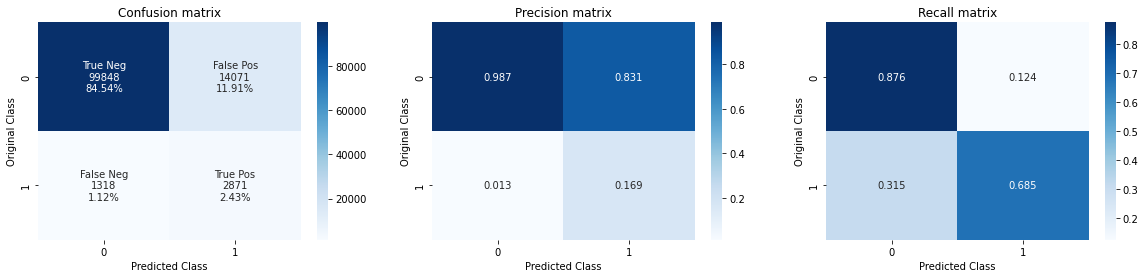

In [17]:
weighted_results = weighted_model.evaluate(val_features, val_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

print('Test confusion_matrix')
plot_confusion_matrix(val_labels, val_predictions_weighted >0.5)

In [18]:
y_pred_test = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
submission = {}
submission.update(dict(zip(test_data['TransactionID_x'],y_pred_test)))
submission = pd.DataFrame.from_dict(submission, orient="index").reset_index()
submission.columns = ["TransactionID", "isFraud"]
submission.to_csv('/gdrive/My Drive/AIML/Project/submission3.csv',index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.115361
1,3663550,0.328533
2,3663551,0.462967
3,3663552,0.150531
4,3663553,0.128603
